In [2]:
from gibbs.dataclass import GibbsResult,get_results
import numpy as np
from gibbs.utils import simple_purify_hamiltonian,printarray,spectral_dec
import matplotlib.pyplot as plt
from gibbs.learning.bayesian_learning import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from gibbs.plots.plots import compare_preparations, axis_locality
import plotly_express as px
from qiskit.quantum_info import state_fidelity

%load_ext autoreload
%autoreload 2
gibbsresults = get_results("../scripts_lap/job_13_qasm")
print(len(gibbsresults))
# for g in gibbsresults:
#     print(g.num_qubits)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
10


In [3]:
timestep = -1
compare_preparations(gibbsresults,[f"{i}" for i in range(len(gibbsresults))],timestep).show()
print(f"VarQITE prepares a state with infidelity {1-gibbsresults[0].fidelity(timestep):.3e} with respect to the original state")

VarQITE prepares a state with infidelity 2.150e-02 with respect to the original state


In [45]:
c_original_prior = gibbsresults[0].coriginal
control_error_vectors = [np.real((r.cfaulties[timestep]-gibbsresults[0].cfaulties[timestep]) - (r.coriginal - gibbsresults[0].coriginal)) for r in gibbsresults]
control_noise=np.concatenate(control_error_vectors)
control_noise = control_noise[control_noise>1e-8]
control_noise = np.std(control_noise)
prep_noise = np.std(gibbsresults[0].cfaulties[timestep]-c_original_prior)
# fig = px.bar(y=np.real(gibbsresults[0].cfaulties[-1]-c_original_prior),barmode="group")
fig = px.bar(y=control_error_vectors[:5],barmode="overlay")
fig.show()
print(f"We get control noise and preparation noise of {control_noise:.3e} and {prep_noise:.3e} respectively.")

We get control noise and preparation noise of 1.748e-02 and 1.134e-01 respectively.


In [50]:
states = [g.state_ansatz(timestep) for g in gibbsresults]
control_fields = [g.coriginal-gibbsresults[0].coriginal for g in gibbsresults]

shots = 1e5
initial_arguments = {
    "states":states,
    "control_fields": control_fields,
    "cmat_factory": ConstraintMatrixFactory(gibbsresults[0].num_qubits,2,2,True),
    "prior_mean": c_original_prior,
    "prior_covariance": (prep_noise,control_noise),
    "sampling_std": 1/np.sqrt(shots),
    "shots": shots
    }
bl = BayesianLearning(**initial_arguments)




In [51]:
A = bl.block_control_matrix(range(4))
print(A.shape)
s,v = spectral_dec(A)

(288, 288)


/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning:

Casting complex values to real discards the imaginary part



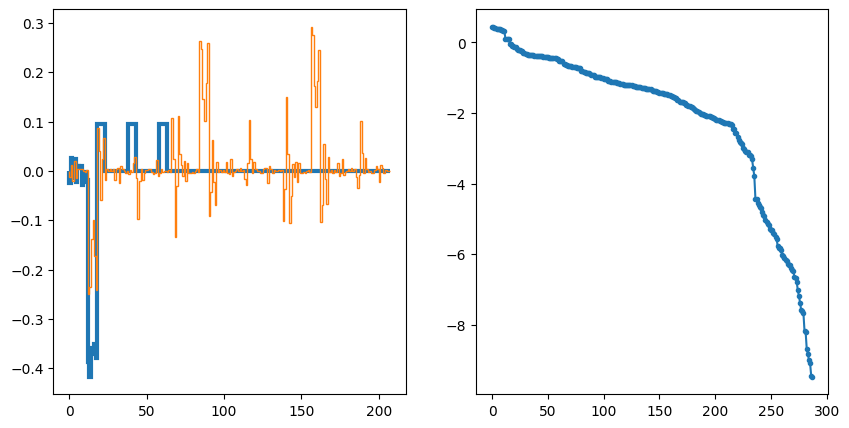

In [52]:
candidate = v[-1][:c_original_prior.size].copy(); candidate /= np.linalg.norm(candidate)
if np.linalg.norm(c_original_prior/np.linalg.norm(c_original_prior) + candidate) < np.linalg.norm(c_original_prior/np.linalg.norm(c_original_prior) - candidate):
    candidate = -candidate  
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stairs(c_original_prior/np.linalg.norm(c_original_prior),lw=3)
ax[0].stairs(candidate)
ax[1].plot(np.log(s),marker=".")

In [53]:
means = [bl.current_mean]
covs = [bl.total_cov]
for indexes in [(0,1,2,3),(0,4,5,6),(0,7,8,9),(0,10,11,12),(0,13,14,15)]:
    posterior_mean = bl.update_mean(indexes,options={"maxiter": 100, "xrtol": 1e-3  , "disp": True})
    posterior_cov = bl.update_cov(posterior_mean,indexes)
    means.append(bl.current_mean)
    covs.append(bl.total_cov)


4 (288, 288) (828,) (207,)


AssertionError: Size of x0: 828 and constraint matrix: (288, 288) don't match

In [ ]:
px.imshow(np.abs(covs[-1])).show()

In [ ]:
df = {
    "Ho":np.real(c_original_prior),
    "Pauli Basis":gibbsresults[0].basis.paulis_list,
    "Learned": np.real(bl.current_mean),
    "Preparation":np.real(gibbsresults[0].cfaulties[timestep]),
    "Covariance": np.real(np.diagonal(bl.current_cov)   ) 
}
fig = px.bar(df,x='Pauli Basis',y=['Ho','Preparation','Learned','Covariance'],barmode="group")
fig.show()
print(f"The prior has a fidelity of {state_fidelity(gibbsresults[0].state_vector(timestep),simple_purify_hamiltonian(gibbsresults[0].basis.vector_to_pauli_op(df['Ho'])))} with the preparation")
print(f"The posterior has a fidelity of {state_fidelity(gibbsresults[0].state_vector(timestep),simple_purify_hamiltonian(gibbsresults[0].basis.vector_to_pauli_op(df['Learned'])))} with the preparation")

In [ ]:
prob = bl.minimization_problem([0,2])
print(prob["x0"].shape)
print(bl._single_block_cond_cov(prob["x0"],2,1))